In [1]:
# Design CIS 3D color router
# Resoultion 20 
# RGGB pattern
# Elapsed run time = 33956.9432 s


# ## 1. Simulation Environment

import meep as mp
import meep.adjoint as mpa
import numpy as np
import nlopt
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
from matplotlib import pyplot as plt
import os

mp.verbosity(1)

seed = 240  # 난수 발생 시드(seed)를 240으로 설정 (재현성을 위해 난수 시드를 고정)
np.random.seed(seed)  # numpy의 난수 생성기의 시드를 설정하여 난수의 재현성 보장

design_dir = "./CIS_design/"

# 디렉터리가 없으면 생성
if not os.path.exists(design_dir):
    os.makedirs(design_dir)

# scaling & refractive index
um_scale = 1 # 1A = 675nm

Air = mp.Medium(index=1.0)
SiN = mp.Medium(index=1.5)
SiO2 = mp.Medium(index=1.5)
HfO2 = mp.Medium(index=1.9)
# SiPD = mp.Medium(epsilon=11.8)

# 해상도 및 사이즈 설정
resolution = 20 # 1 pixel = 27nm
Lpml = 0.5 # PML 영역 크기
# pml_layers = [mp.PML(thickness = Lpml, direction = mp.Z)]
pml_layers = [mp.PML(thickness = Lpml, )]
Sourcespace = 0.5

# 설계 공간
design_region_width_x = 0.5 # 디자인 영역 x
design_region_width_y = 0.5 # 디자인 영역 y
design_region_height = 0.5 # 디자인 영역 높이 z

# 전체 공간
Sx = design_region_width_x +Lpml*2 + 1
Sy = design_region_width_y+Lpml*2 + 1
Sz = Lpml + design_region_height + Sourcespace + 1 + Lpml
cell_size = mp.Vector3(Sx, Sy, Sz)

# 파장, 주파수 설정
wavelengths = np.array([0.3, 0.4, 0.5])
frequencies = 1/wavelengths
nf = len(frequencies) # number of frequencies

# Fabrication Constraints 설정

minimum_length = 0.027 * um_scale # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
design_region_resolution = int(resolution)


# source 설정
fcen = 1 / 0.5
width = 0.1
fwidth = width * fcen

source_center = [0, 0, Sz / 2 - Lpml - Sourcespace / 2 ] # Source 위치
source_size = mp.Vector3(Sx, Sy, 0)
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)

source = [mp.Source(src, component=mp.Ex, size=source_size, center=source_center,),]


# 설계 영역의 픽셀 - 해상도와 디자인 영역에 따라 결정
Nx = int(round(design_region_resolution * design_region_width_x)) 
Ny = int(round(design_region_resolution * design_region_width_y)) 
Nz = int(round(design_region_resolution * design_region_height))

# 설계 영역과 물질을 바탕으로 설계 영역 설정
design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny, Nz), Air, SiN, grid_type="U_MEAN",do_averaging=False)
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, 0, Sz / 2 - Lpml - Sourcespace - design_region_height/2),
        size=mp.Vector3(design_region_width_x, design_region_width_y, design_region_height),
    ),
)

# 대각선대칭

def mapping(x, eta, beta):
    x_copy = (x.reshape(Nx * Ny, Nz)).transpose()

    # projection
    z = 0
    x2 = []

    while z < Nz:
        
        number = z
        x1 = x_copy[int(number)]
        
        # filter
        filtered_field = mpa.conic_filter(
            x1,
            filter_radius,
            0.88,
            0.88,
            design_region_resolution,
        )
        
        z_slice = ((filtered_field.reshape(Nx, Ny)) + filtered_field.reshape(Nx, Ny).transpose()) / 2
        x2 = npa.concatenate((x2,z_slice.flatten()),axis=0) 
        z = z + 1

    x2 = ((x2.reshape(Nz,Nx*Ny)).transpose()).flatten()
    
    x2 = (x2.reshape(Nx * Ny, Nz)).transpose()
        
    # Compute the mean for the pairs of columns
    mean_columns_1layer = npa.mean(x2[:8, :], axis=0)  # Mean for columns 
    mean_columns_2layer = npa.mean(x2[9:17, :], axis=0)  # Mean for columns 
    mean_columns_3layer = npa.mean(x2[18:26, :], axis=0)  # Mean for columns 
    mean_columns_4layer = npa.mean(x2[27:35, :], axis=0)  # Mean for columns 
    mean_columns_5layer = npa.mean(x2[36:44, :], axis=0)  # Mean for columns 
    
    # Create new arrays with mean values
    new_x2_1layer = npa.tile(mean_columns_1layer, 8).reshape(8, -1).flatten()
    new_x2_1layer_e = npa.zeros(Nx * Ny).flatten()
    new_x2_2layer = npa.tile(mean_columns_2layer, 8).reshape(8, -1).flatten()
    new_x2_2layer_e = npa.zeros(Nx * Ny).flatten()
    new_x2_3layer = npa.tile(mean_columns_3layer, 8).reshape(8, -1).flatten()
    new_x2_3layer_e = npa.zeros(Nx * Ny).flatten()
    new_x2_4layer = npa.tile(mean_columns_4layer, 8).reshape(8, -1).flatten()
    new_x2_4layer_e = npa.zeros(Nx * Ny).flatten()
    new_x2_5layer = npa.tile(mean_columns_5layer, 8).reshape(8, -1).flatten()
    
    # Concatenate the arrays to get the final result
    x2 = npa.concatenate([new_x2_1layer, new_x2_1layer_e,new_x2_2layer, new_x2_2layer_e,new_x2_3layer, new_x2_3layer_e,new_x2_4layer, new_x2_4layer_e,new_x2_5layer],axis=0)
    x2 = ((x2.reshape(Nz,Nx*Ny)).transpose()).flatten()
    x2 = mpa.tanh_projection(x2, beta, eta).flatten()
    x = x2

    return x


# design region과 동일한 size의 Block 생성
geometry = [
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ),
]

# Meep simulation 세팅

sim = mp.Simulation(
    cell_size=cell_size, 
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air, # 빈공간
    resolution=resolution,
    k_point = mp.Vector3(0,0,0)
)

###############################################################################################################################
# ## 2. Optimization Environment

# 모니터 위치와 크기 설정 (focal point)
monitor_position_0, monitor_size_0 = mp.Vector3(-design_region_width_x/2, design_region_width_y/2, -Sz/2 + Lpml + 0.5/resolution), mp.Vector3(0.01,0.01,0) 


# FourierFields를 통해 monitor_position에서 monitor_size만큼의 영역에 대한 Fourier transform을 구함

FourierFields_0_x = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ex,yee_grid=True)


ob_list = [FourierFields_0_x]


# J : Objective function
# FourierFields가 측정한 필드, 모니터의 중심에서 E 구성요소의 절댓값을 제곱한 값을 취한 후 평균을 계산하여 평균 강도를 계산
# [frequency index, moniter index]
def J(fields):
    return npa.mean(npa.abs(fields[:,1]) ** 2)

# optimization 설정

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    decay_by=1e-3,
)

# 함수 설정

evaluation_history = []
cur_iter = [0]
numevl = 1

def f(v, gradient, beta):
    global numevl
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, beta)])  # compute objective and gradient
    # f0, dJ_du = opt()

    # Adjoint gradient
    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, beta, np.sum(dJ_du, axis=1)
        )  # backprop

    evaluation_history.append(np.real(f0))

    np.savetxt(design_dir+"structure_0"+str(numevl) +".txt", design_variables.weights)
    
    numevl += 1
    
    print("First FoM: {}".format(evaluation_history[0]))
    print("Current FoM: {}".format(np.real(f0)))

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)

     block, center = (0,0,0.25)
          size (0.5,0.5,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)


/home/user/anaconda3/envs/mp/lib/python3.11/site-packages/meep/visualization.py:271: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


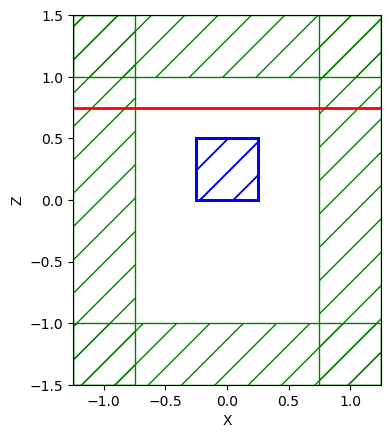

In [2]:
opt.plot2D(True,output_plane = mp.Volume(size = (np.inf, 0, np.inf), center = (0,0,0)))

In [3]:
print(design_variables.weights)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [4]:
f0, dJ_du = opt()

Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000192165 s
Working in 3D dimensions.
Computational cell is 2.5 x 2.5 x 3 with resolution 20
     block, center = (0,0,0.25)
          size (0.5,0.5,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.134189 s
-----------
on time step 906 (time=22.65), 0.00441539 s/step
on time step 1899 (time=47.475), 0.00402835 s/step
run 0 finished at t = 50.050000000000004 (2002 timesteps)
Starting adjoint run...


/home/user/anaconda3/envs/mp/lib/python3.11/site-packages/meep/adjoint/filter_source.py:175: RuntimeWarning: invalid value encountered in divide
  l2_err = np.sum(np.abs(H - H_hat.T) ** 2 / np.abs(H) ** 2)


run 1 finished at t = 4.1000000000000005 (164 timesteps)
Calculating gradient...


In [5]:
print(dJ_du)
print(f0)


[[-8.36450961e-15 -5.17372665e-14 -3.13946035e-05]
 [ 1.80474553e-14  2.42163828e-14  1.37270315e-04]
 [ 4.64590217e-14  2.72842176e-14  2.53212673e-04]
 ...
 [-2.46853827e-14  7.31729529e-15  9.95005212e-04]
 [-1.64510840e-14 -1.77785141e-16  1.11359614e-03]
 [-3.15528317e-14  3.60714661e-14  1.88791006e-03]]
0.5934275605324557


In [6]:
print(design_variables.weights)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [7]:
db = 1e-5
choose = 1000
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose, db=db)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000240803 s
Working in 3D dimensions.
Computational cell is 2.5 x 2.5 x 3 with resolution 20
     block, center = (0,0,0.25)
          size (0.5,0.5,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.149207 s
-----------
on time step 914 (time=22.85), 0.00437772 s/step
on time step 1906 (time=47.65), 0.00403478 s/step
run 2 finished at t = 50.125 (2005 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000170946 s
Working in 3D dimensions.
Computational cell is 2.5 x 2.5 x 3 with resolution 20
     block, center = (0,0,0.25)
          size (0.5,0.5,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.138173 s
-----------
on time step 914 (time=22.85), 0.00437738 s/step
on time step 1904 (time=47.6), 0.00404165 s/step
run 3 finished at t = 50.125 (2005 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000183821 s
W

In [8]:
# print(g_discrete)

In [9]:
# g_discrete1 = np.squeeze(g_discrete).reshape(2,2,2).transpose(2,1,0).flatten()

In [10]:
# (m, b) = np.polyfit(np.squeeze(g_discrete1), dJ_du[idx], 1)

In [11]:
# min_g = np.min(g_discrete1)
# max_g = np.max(g_discrete1)

# fig = plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.plot([min_g, max_g], [min_g, max_g], label="y=x comparison")
# plt.plot([min_g, max_g], [m * min_g + b, m * max_g + b], "--", label="Best fit")
# plt.plot(g_discrete1, dJ_du[idx], "o", label="Adjoint comparison")
# plt.xlabel("Finite Difference Gradient")
# plt.ylabel("Adjoint Gradient")
# plt.legend()
# plt.grid(True)
# plt.axis("square")

# plt.subplot(1, 2, 2)
# rel_err = (
#     np.abs(np.squeeze(g_discrete1) - np.squeeze(dJ_du[idx]))
#     / np.abs(np.squeeze(g_discrete1))
#     * 100
# )
# plt.semilogy(g_discrete1, rel_err, "o")
# plt.grid(True)
# plt.xlabel("Finite Difference Gradient")
# plt.ylabel("Relative Error (%)")
# plt.show()

# plt.savefig("graph.png")
# plt.cla()   # clear the current axes
# plt.clf()   # clear the current figure
# plt.close() # closes the current figure
# plt.show()

In [12]:
dJ_du_sum = np.sum(dJ_du[:], axis=1)

In [13]:
(m, b) = np.polyfit(np.squeeze(g_discrete), dJ_du_sum[idx], 1)

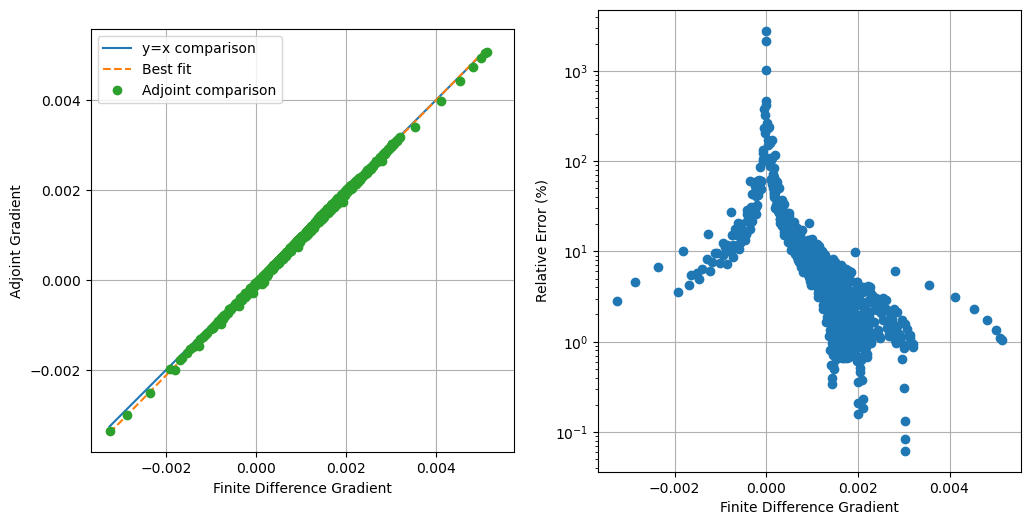

In [14]:
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g, max_g], [min_g, max_g], label="y=x comparison")
plt.plot([min_g, max_g], [m * min_g + b, m * max_g + b], "--", label="Best fit")
plt.plot(g_discrete, dJ_du_sum[idx], "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err = (
    np.abs(np.squeeze(g_discrete) - np.squeeze(dJ_du_sum[idx]))
    / np.abs(np.squeeze(g_discrete))
    * 100
)
plt.semilogy(g_discrete, rel_err, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")
plt.show()

plt.savefig("graph.png")
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() # closes the current figure
plt.show()

     block, center = (0,0,0.25)
          size (0.5,0.5,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)


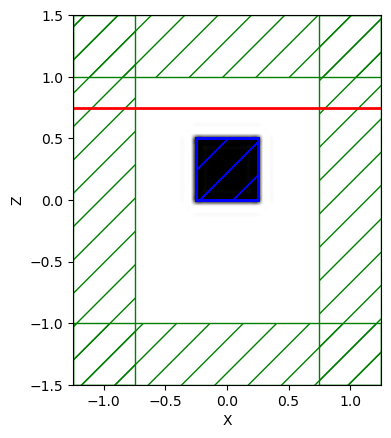

In [15]:
opt.plot2D(True,output_plane = mp.Volume(size = (np.inf, 0, np.inf), center = (0,0,0)))

In [16]:
print(design_variables.weights)

[1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05
 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05
 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05
 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05
 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05
 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05
 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05
 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05
 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05
 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05
 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05
 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05
 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05
 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05
 1.e-0